In [1]:
# Data manipulation and analysis
import pandas as pd

# Scikit-learn modules
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              AdaBoostClassifier, BaggingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# XGBoost
from xgboost import XGBRegressor, XGBRFRegressor
import lightgbm as lgb

# CatBoost
from catboost import CatBoostRegressor

# Date and time
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.options.mode.chained_assignment = None 
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, GroupKFold, KFold

from tqdm.notebook import tqdm

import optuna
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
transcations_df = pd.read_csv('transactions.csv')

In [3]:
train_df

,doj,srcid,destid,final_seatcount
0,2023-03-01,45,46,2838.0
1,2023-03-01,46,45,2298.0
2,2023-03-01,45,47,2720.0
3,2023-03-01,47,45,2580.0
4,2023-03-01,46,9,4185.0
...,...,...,...,...
67195,2024-12-31,2,24,800.0
67196,2024-12-31,44,45,1360.0
67197,2024-12-31,47,10,560.0
67198,2024-12-31,38,36,535.0


In [4]:
test_df

,route_key,doj,srcid,destid
0,2025-02-11_46_45,2025-02-11,46,45
1,2025-01-20_17_23,2025-01-20,17,23
2,2025-01-08_02_14,2025-01-08,2,14
3,2025-01-08_08_47,2025-01-08,8,47
4,2025-01-08_09_46,2025-01-08,9,46
...,...,...,...,...
5895,2025-01-23_46_48,2025-01-23,46,48
5896,2025-02-21_46_09,2025-02-21,46,9
5897,2025-01-17_32_19,2025-01-17,32,19
5898,2025-01-24_45_03,2025-01-24,45,3


In [5]:
transcations_df

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8.0,76.0,30
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8.0,70.0,30
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4.0,142.0,30
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0.0,68.0,30
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,162.0,30
...,...,...,...,...,...,...,...,...,...,...,...
2266095,2025-02-28,2025-02-28,2,24,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,0.0,0.0,0
2266096,2025-02-28,2025-02-28,44,45,Tamil Nadu,Karnataka,Tier2,Tier 1,0.0,0.0,0
2266097,2025-02-28,2025-02-28,47,10,Andhra Pradesh,Andhra Pradesh,Tier 1,Tier 3,0.0,0.0,0
2266098,2025-02-28,2025-02-28,38,36,Rest of North,Delhi,Tier 1,Tier2,0.0,0.0,0


In [6]:
trans_15d = transcations_df[transcations_df['dbd'] == 15]

# 3. Prepare training features
train_merged = pd.merge(train_df, trans_15d, on=['doj', 'srcid', 'destid'], how='left')

# 4. Prepare test features
test_merged = pd.merge(test_df, trans_15d, on=['doj', 'srcid', 'destid'], how='left')

In [7]:
train_merged

,doj,srcid,destid,final_seatcount,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2023-03-01,45,46,2838.0,2023-02-14,Karnataka,Tamil Nadu,Tier 1,Tier 1,16.0,480.0,15
1,2023-03-01,46,45,2298.0,2023-02-14,Tamil Nadu,Karnataka,Tier 1,Tier 1,34.0,352.0,15
2,2023-03-01,45,47,2720.0,2023-02-14,Karnataka,Andhra Pradesh,Tier 1,Tier 1,36.0,892.0,15
3,2023-03-01,47,45,2580.0,2023-02-14,Andhra Pradesh,Karnataka,Tier 1,Tier 1,18.0,1130.0,15
4,2023-03-01,46,9,4185.0,2023-02-14,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,48.0,1023.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
67195,2024-12-31,2,24,800.0,2024-12-16,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,20.0,1300.0,15
67196,2024-12-31,44,45,1360.0,2024-12-16,Tamil Nadu,Karnataka,Tier2,Tier 1,75.0,1220.0,15
67197,2024-12-31,47,10,560.0,2024-12-16,Andhra Pradesh,Andhra Pradesh,Tier 1,Tier 3,15.0,1560.0,15
67198,2024-12-31,38,36,535.0,2024-12-16,Rest of North,Delhi,Tier 1,Tier2,0.0,340.0,15


In [8]:
test_merged

,route_key,doj,srcid,destid,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2025-02-11_46_45,2025-02-11,46,45,2025-01-27,Tamil Nadu,Karnataka,Tier 1,Tier 1,38.0,1082.0,15
1,2025-01-20_17_23,2025-01-20,17,23,2025-01-05,East 1,East 1,Tier2,Tier 1,0.0,1175.0,15
2,2025-01-08_02_14,2025-01-08,2,14,2024-12-24,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,0.0,370.0,15
3,2025-01-08_08_47,2025-01-08,8,47,2024-12-24,Andhra Pradesh,Andhra Pradesh,Tier2,Tier 1,0.0,120.0,15
4,2025-01-08_09_46,2025-01-08,9,46,2024-12-24,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,39.0,1230.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
5895,2025-01-23_46_48,2025-01-23,46,48,2025-01-08,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,126.0,4578.0,15
5896,2025-02-21_46_09,2025-02-21,46,9,2025-02-06,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,249.0,11337.0,15
5897,2025-01-17_32_19,2025-01-17,32,19,2025-01-02,Madhya Pradesh,Madhya Pradesh,Tier 1,Tier 1,4.0,408.0,15
5898,2025-01-24_45_03,2025-01-24,45,3,2025-01-09,Karnataka,Andhra Pradesh,Tier 1,Tier2,4.0,1132.0,15


In [9]:
sample_submission = pd.read_csv('solution_format.csv')
sample_submission

,route_key,final_seatcount
0,2025-02-11_46_45,0
1,2025-01-20_17_23,0
2,2025-01-08_02_14,0
3,2025-01-08_08_47,0
4,2025-01-08_09_46,0
...,...,...
5895,2025-01-23_46_48,0
5896,2025-02-21_46_09,0
5897,2025-01-17_32_19,0
5898,2025-01-24_45_03,0


In [10]:
# # Start by filtering all relevant transaction data with dbd in [15, 30]
lag_data = transcations_df[(transcations_df['dbd'] > 15) & (transcations_df['dbd'] <= 30)]

# We'll pivot this table so that each dbd becomes a column
seatcount_pivot = lag_data.pivot_table(
    index=['doj', 'srcid', 'destid'],
    columns='dbd',
    values='cumsum_seatcount'
).add_prefix('seatcount_lag_').reset_index()

searchcount_pivot = lag_data.pivot_table(
    index=['doj', 'srcid', 'destid'],
    columns='dbd',
    values='cumsum_searchcount'
).add_prefix('searchcount_lag_').reset_index()

# Merge both lag feature sets
lag_features = pd.merge(seatcount_pivot, searchcount_pivot, on=['doj', 'srcid', 'destid'], how='outer')

# Merge with your existing train_merged (which only contains dbd == 15)
train_with_lags = pd.merge(train_merged, lag_features, on=['doj', 'srcid', 'destid'], how='left')
test_with_lags = pd.merge(test_merged, lag_features, on=['doj', 'srcid', 'destid'], how='left')

# train_with_lags = train_merged
# test_with_lags = test_merged

In [11]:
train_with_lags

,doj,srcid,destid,final_seatcount,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,seatcount_lag_16,seatcount_lag_17,seatcount_lag_18,seatcount_lag_19,seatcount_lag_20,seatcount_lag_21,seatcount_lag_22,seatcount_lag_23,seatcount_lag_24,seatcount_lag_25,seatcount_lag_26,seatcount_lag_27,seatcount_lag_28,seatcount_lag_29,seatcount_lag_30,searchcount_lag_16,searchcount_lag_17,searchcount_lag_18,searchcount_lag_19,searchcount_lag_20,searchcount_lag_21,searchcount_lag_22,searchcount_lag_23,searchcount_lag_24,searchcount_lag_25,searchcount_lag_26,searchcount_lag_27,searchcount_lag_28,searchcount_lag_29,searchcount_lag_30
0,2023-03-01,45,46,2838.0,2023-02-14,Karnataka,Tamil Nadu,Tier 1,Tier 1,16.0,480.0,15,16.0,14.0,14.0,14.0,14.0,14.0,14.0,10.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,448.0,420.0,360.0,320.0,300.0,280.0,274.0,246.0,214.0,198.0,146.0,126.0,108.0,94.0,76.0
1,2023-03-01,46,45,2298.0,2023-02-14,Tamil Nadu,Karnataka,Tier 1,Tier 1,34.0,352.0,15,32.0,32.0,30.0,30.0,28.0,26.0,26.0,22.0,22.0,22.0,18.0,18.0,10.0,8.0,8.0,324.0,304.0,288.0,254.0,228.0,208.0,182.0,146.0,114.0,112.0,96.0,96.0,94.0,88.0,70.0
2,2023-03-01,45,47,2720.0,2023-02-14,Karnataka,Andhra Pradesh,Tier 1,Tier 1,36.0,892.0,15,30.0,24.0,18.0,18.0,18.0,16.0,16.0,14.0,12.0,10.0,8.0,8.0,6.0,4.0,4.0,796.0,710.0,670.0,596.0,554.0,520.0,430.0,386.0,366.0,348.0,286.0,208.0,196.0,176.0,142.0
3,2023-03-01,47,45,2580.0,2023-02-14,Andhra Pradesh,Karnataka,Tier 1,Tier 1,18.0,1130.0,15,18.0,18.0,6.0,6.0,6.0,6.0,6.0,6.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,1080.0,952.0,912.0,822.0,814.0,608.0,562.0,446.0,398.0,318.0,222.0,174.0,168.0,110.0,68.0
4,2023-03-01,46,9,4185.0,2023-02-14,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,48.0,1023.0,15,39.0,36.0,36.0,36.0,33.0,27.0,21.0,18.0,12.0,9.0,9.0,9.0,9.0,9.0,9.0,876.0,702.0,537.0,474.0,444.0,384.0,372.0,351.0,324.0,303.0,267.0,249.0,210.0,168.0,162.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67195,2024-12-31,2,24,800.0,2024-12-16,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,20.0,1300.0,15,20.0,20.0,20.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1195.0,1140.0,1110.0,1050.0,925.0,810.0,690.0,670.0,560.0,540.0,520.0,485.0,445.0,395.0,315.0
67196,2024-12-31,44,45,1360.0,2024-12-16,Tamil Nadu,Karnataka,Tier2,Tier 1,75.0,1220.0,15,75.0,75.0,65.0,60.0,60.0,60.0,60.0,60.0,60.0,55.0,55.0,55.0,55.0,55.0,55.0,1175.0,1100.0,1040.0,935.0,920.0,920.0,870.0,715.0,675.0,595.0,535.0,475.0,385.0,315.0,290.0
67197,2024-12-31,47,10,560.0,2024-12-16,Andhra Pradesh,Andhra Pradesh,Tier 1,Tier 3,15.0,1560.0,15,15.0,15.0,15.0,15.0,15.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,1545.0,1545.0,1305.0,1305.0,1260.0,1160.0,1050.0,970.0,755.0,720.0,695.0,695.0,695.0,435.0,175.0
67198,2024-12-31,38,36,535.0,2024-12-16,Rest of North,Delhi,Tier 1,Tier2,0.0,340.0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280.0,255.0,255.0,195.0,195.0,195.0,195.0,175.0,175.0,160.0,160.0,150.0,150.0,150.0,150.0


In [12]:
test_with_lags

,route_key,doj,srcid,destid,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd,seatcount_lag_16,seatcount_lag_17,seatcount_lag_18,seatcount_lag_19,seatcount_lag_20,seatcount_lag_21,seatcount_lag_22,seatcount_lag_23,seatcount_lag_24,seatcount_lag_25,seatcount_lag_26,seatcount_lag_27,seatcount_lag_28,seatcount_lag_29,seatcount_lag_30,searchcount_lag_16,searchcount_lag_17,searchcount_lag_18,searchcount_lag_19,searchcount_lag_20,searchcount_lag_21,searchcount_lag_22,searchcount_lag_23,searchcount_lag_24,searchcount_lag_25,searchcount_lag_26,searchcount_lag_27,searchcount_lag_28,searchcount_lag_29,searchcount_lag_30
0,2025-02-11_46_45,2025-02-11,46,45,2025-01-27,Tamil Nadu,Karnataka,Tier 1,Tier 1,38.0,1082.0,15,32.0,28.0,24.0,14.0,10.0,10.0,8.0,6.0,6.0,6.0,6.0,6.0,4.0,4.0,4.0,970.0,896.0,820.0,740.0,584.0,450.0,418.0,362.0,322.0,238.0,234.0,222.0,200.0,182.0,146.0
1,2025-01-20_17_23,2025-01-20,17,23,2025-01-05,East 1,East 1,Tier2,Tier 1,0.0,1175.0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,940.0,765.0,700.0,505.0,485.0,455.0,405.0,340.0,320.0,310.0,290.0,270.0,255.0,90.0,90.0
2,2025-01-08_02_14,2025-01-08,2,14,2024-12-24,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,0.0,370.0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,325.0,180.0,180.0,170.0,170.0,140.0,130.0,130.0,130.0,130.0,130.0,130.0,50.0,50.0,20.0
3,2025-01-08_08_47,2025-01-08,8,47,2024-12-24,Andhra Pradesh,Andhra Pradesh,Tier2,Tier 1,0.0,120.0,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105.0,75.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
4,2025-01-08_09_46,2025-01-08,9,46,2024-12-24,Tamil Nadu,Tamil Nadu,Tier2,Tier 1,39.0,1230.0,15,27.0,27.0,27.0,27.0,24.0,21.0,21.0,21.0,15.0,15.0,15.0,15.0,6.0,6.0,6.0,1029.0,870.0,741.0,660.0,555.0,408.0,378.0,375.0,303.0,234.0,216.0,210.0,189.0,165.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5895,2025-01-23_46_48,2025-01-23,46,48,2025-01-08,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,126.0,4578.0,15,117.0,111.0,108.0,99.0,87.0,87.0,69.0,48.0,42.0,42.0,33.0,24.0,6.0,6.0,6.0,4173.0,3912.0,3687.0,3246.0,2970.0,2679.0,2259.0,1914.0,1785.0,1602.0,1419.0,1359.0,1200.0,1014.0,816.0
5896,2025-02-21_46_09,2025-02-21,46,9,2025-02-06,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,249.0,11337.0,15,204.0,180.0,168.0,162.0,123.0,108.0,99.0,81.0,75.0,72.0,72.0,57.0,57.0,12.0,12.0,9792.0,8976.0,7740.0,6441.0,5520.0,4920.0,4458.0,4059.0,3561.0,3282.0,2766.0,2238.0,1914.0,1497.0,1401.0
5897,2025-01-17_32_19,2025-01-17,32,19,2025-01-02,Madhya Pradesh,Madhya Pradesh,Tier 1,Tier 1,4.0,408.0,15,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,288.0,288.0,264.0,216.0,176.0,84.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0,76.0
5898,2025-01-24_45_03,2025-01-24,45,3,2025-01-09,Karnataka,Andhra Pradesh,Tier 1,Tier2,4.0,1132.0,15,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,1020.0,880.0,824.0,776.0,568.0,452.0,416.0,344.0,332.0,316.0,272.0,264.0,256.0,244.0,200.0


In [13]:
# Log-transform all cumsum_seatcount, cumsum_searchcount, seatcount_lag, and searchcount_lag columns

cols_to_log_transform = [
    'cumsum_seatcount', 
    'cumsum_searchcount'
] + [col for col in train_with_lags.columns if col.startswith('seatcount_lag_') or col.startswith('searchcount_lag_')]
for col in cols_to_log_transform:
    train_with_lags[col] = np.log1p(train_with_lags[col])
    test_with_lags[col] = np.log1p(test_with_lags[col])

In [14]:
# test_with_lags['seatcount_density'] = test_with_lags['cumsum_seatcount'] / (test_with_lags['dbd'].clip(lower=1))
# train_with_lags['seatcount_density'] = train_with_lags['cumsum_seatcount'] / (train_with_lags['dbd'].clip(lower=1))

In [15]:
test_with_lags.drop(['route_key', 'dbd'], axis=1, inplace=True)
train_with_lags.drop(['dbd'], axis=1, inplace=True)

In [16]:
combo_df = pd.concat([train_with_lags.drop('final_seatcount', axis=1), test_with_lags], ignore_index=True)
combo_df

,doj,srcid,destid,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,seatcount_lag_16,seatcount_lag_17,seatcount_lag_18,seatcount_lag_19,seatcount_lag_20,seatcount_lag_21,seatcount_lag_22,seatcount_lag_23,seatcount_lag_24,seatcount_lag_25,seatcount_lag_26,seatcount_lag_27,seatcount_lag_28,seatcount_lag_29,seatcount_lag_30,searchcount_lag_16,searchcount_lag_17,searchcount_lag_18,searchcount_lag_19,searchcount_lag_20,searchcount_lag_21,searchcount_lag_22,searchcount_lag_23,searchcount_lag_24,searchcount_lag_25,searchcount_lag_26,searchcount_lag_27,searchcount_lag_28,searchcount_lag_29,searchcount_lag_30
0,2023-03-01,45,46,2023-02-14,Karnataka,Tamil Nadu,Tier 1,Tier 1,2.833213,6.175867,2.833213,2.708050,2.708050,2.708050,2.708050,2.708050,2.708050,2.397895,2.197225,2.197225,2.197225,2.197225,2.197225,2.197225,2.197225,6.107023,6.042633,5.888878,5.771441,5.707110,5.638355,5.616771,5.509388,5.370638,5.293305,4.990433,4.844187,4.691348,4.553877,4.343805
1,2023-03-01,46,45,2023-02-14,Tamil Nadu,Karnataka,Tier 1,Tier 1,3.555348,5.866468,3.496508,3.496508,3.433987,3.433987,3.367296,3.295837,3.295837,3.135494,3.135494,3.135494,2.944439,2.944439,2.397895,2.197225,2.197225,5.783825,5.720312,5.666427,5.541264,5.433722,5.342334,5.209486,4.990433,4.744932,4.727388,4.574711,4.574711,4.553877,4.488636,4.262680
2,2023-03-01,45,47,2023-02-14,Karnataka,Andhra Pradesh,Tier 1,Tier 1,3.610918,6.794587,3.433987,3.218876,2.944439,2.944439,2.944439,2.833213,2.833213,2.708050,2.564949,2.397895,2.197225,2.197225,1.945910,1.609438,1.609438,6.680855,6.566672,6.508769,6.391917,6.318968,6.255750,6.066108,5.958425,5.905362,5.855072,5.659482,5.342334,5.283204,5.176150,4.962845
3,2023-03-01,47,45,2023-02-14,Andhra Pradesh,Karnataka,Tier 1,Tier 1,2.944439,7.030857,2.944439,2.944439,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910,1.609438,1.609438,1.609438,0.000000,0.000000,0.000000,0.000000,6.985642,6.859615,6.816736,6.712956,6.703188,6.411818,6.333280,6.102559,5.988961,5.765191,5.407172,5.164786,5.129899,4.709530,4.234107
4,2023-03-01,46,9,2023-02-14,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,3.891820,6.931472,3.688879,3.610918,3.610918,3.610918,3.526361,3.332205,3.091042,2.944439,2.564949,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,6.776507,6.555357,6.287859,6.163315,6.098074,5.953243,5.921578,5.863631,5.783825,5.717028,5.590987,5.521461,5.351858,5.129899,5.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2025-01-23,46,48,2025-01-08,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,4.844187,8.429236,4.770685,4.718499,4.691348,4.605170,4.477337,4.477337,4.248495,3.891820,3.761200,3.761200,3.526361,3.218876,1.945910,1.945910,1.945910,8.336630,8.272060,8.212840,8.085487,7.996654,7.893572,7.723120,7.557473,7.487734,7.379632,7.258412,7.215240,7.090910,6.922644,6.705639
73096,2025-02-21,46,9,2025-02-06,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,5.521461,9.335915,5.323010,5.198497,5.129899,5.093750,4.820282,4.691348,4.605170,4.406719,4.330733,4.290459,4.290459,4.060443,4.060443,2.564949,2.564949,9.189423,9.102421,8.954286,8.770594,8.616314,8.501267,8.402680,8.308938,8.178077,8.096513,7.925519,7.713785,7.557473,7.311886,7.245655
73097,2025-01-17,32,19,2025-01-02,Madhya Pradesh,Madhya Pradesh,Tier 1,Tier 1,1.609438,6.013715,1.609438,1.609438,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.666427,5.666427,5.579730,5.379897,5.176150,4.442651,4.343805,4.343805,4.343805,4.343805,4.343805,4.343805,4.343805,4.343805,4.343805
73098,2025-01-24,45,3,2025-01-09,Karnataka,Andhra Pradesh,Tier 1,Tier2,1.609438,7.032624,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,1.609438,0.000000,0.000000,0.000000,6.928538,6.781058,6.715383,6.655440,6.343880,6.115892,6.033086,5.843544,5.808142,5.758902,5.609472,5.579730,5.549

In [17]:
def create_generalized_rolling_mean(df, metric_name, start_lag, num_lags, feature_name_suffix=""):
    """
    Calculates a generalized rolling mean feature for specified lags.

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric_name (str): The base name of the lag features (e.g., 'seatcount' or 'searchcount').
        start_lag (int): The starting lag number for the rolling window.
        num_lags (int): The number of lags to include in the rolling mean.
        feature_name_suffix (str): An optional suffix to append to the feature name.

    Returns:
        pd.DataFrame: The DataFrame with the new rolling mean feature added.
    """
    lag_columns = [f"{metric_name}_lag_{i}" for i in range(start_lag, start_lag + num_lags)]
    
    # Ensure all required lag columns exist in the DataFrame
    missing_cols = [col for col in lag_columns if col not in df.columns]
    if missing_cols:
        print(f"Warning: The following columns are missing and will be ignored: {missing_cols}")
        lag_columns = [col for col in lag_columns if col in df.columns]
        if not lag_columns:
            print(f"No valid columns found for {metric_name} rolling mean from lag {start_lag} for {num_lags} lags. Skipping feature creation.")
            return df

    new_feature_name = f"{metric_name}_rolling_mean_{start_lag}_{start_lag + num_lags - 1}"
    if feature_name_suffix:
        new_feature_name = f"{metric_name}_rolling_mean_{feature_name_suffix}"

    df[new_feature_name] = df[lag_columns].mean(axis=1)
    return df

# # --- Create various generalized rolling mean features ---

# # Example 1: Rolling mean for lags 16 to 18 (3 lags)
# df = create_generalized_rolling_mean(combo_df, 'seatcount', 16, 3, "16_18")
# df = create_generalized_rolling_mean(combo_df, 'searchcount', 16, 3, "16_18")

# # Example 2: Rolling mean for lags 19 to 21 (3 lags)
# df = create_generalized_rolling_mean(combo_df, 'seatcount', 19, 3, "19_21")
# df = create_generalized_rolling_mean(combo_df, 'searchcount', 19, 3, "19_21")

# # Example 3: Rolling mean for lags 22 to 24 (3 lags)
# df = create_generalized_rolling_mean(combo_df, 'seatcount', 22, 3, "22_24")
# df = create_generalized_rolling_mean(combo_df, 'searchcount', 22, 3, "22_24")


# # Example 4: Rolling mean for lags 25 to 27 (3 lags)
# df = create_generalized_rolling_mean(combo_df, 'seatcount', 25, 3, "25_27")
# df = create_generalized_rolling_mean(combo_df, 'searchcount', 25, 3, "25_27")


# # Example 5: Rolling mean for lags 28 to 30 (3 lags)
# df = create_generalized_rolling_mean(combo_df, 'seatcount', 28, 3, "28_30")
# df = create_generalized_rolling_mean(combo_df, 'searchcount', 28, 3, "28_30")


# combo_df = df
# combo_df






In [18]:
rolling_mean_cols = [col for col in combo_df.columns if 'rolling_mean' in col]
rolling_mean_cols

[]

In [19]:
def create_enhanced_lag_features(combo_df):
    """Create more sophisticated lag features"""
    
    # Keep the existing lag features instead of dropping them
    # Don't drop lag features!
    
    # Create rolling statistics across different windows
    lag_cols = [col for col in combo_df.columns if 'lag_' in col]
    print(f"Found {len(lag_cols)} lag features")
    
    # Short-term trends (16-20 days)
    short_term_seat_cols = [f'seatcount_lag_{i}' for i in range(16, 21) if f'seatcount_lag_{i}' in combo_df.columns]
    short_term_search_cols = [f'searchcount_lag_{i}' for i in range(16, 21) if f'searchcount_lag_{i}' in combo_df.columns]
    
    if short_term_seat_cols:
        combo_df['seat_short_term_mean'] = combo_df[short_term_seat_cols].mean(axis=1)
        combo_df['seat_short_term_std'] = combo_df[short_term_seat_cols].std(axis=1)
        combo_df['seat_short_term_diff'] = combo_df['seatcount_lag_20'] - combo_df['seatcount_lag_16']
        print("Created short-term seat features")

    if short_term_search_cols:
        combo_df['search_short_term_mean'] = combo_df[short_term_search_cols].mean(axis=1)
        combo_df['search_short_term_std'] = combo_df[short_term_search_cols].std(axis=1)
        combo_df['search_short_term_diff'] = combo_df['searchcount_lag_20'] - combo_df['searchcount_lag_16']
        print("Created short-term search features")
    
        return combo_df

# Create enhanced lag features
combo_df = create_enhanced_lag_features(combo_df)
combo_df

Found 30 lag features
Created short-term seat features
Created short-term search features


,doj,srcid,destid,doi,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,seatcount_lag_16,seatcount_lag_17,seatcount_lag_18,seatcount_lag_19,seatcount_lag_20,seatcount_lag_21,seatcount_lag_22,seatcount_lag_23,seatcount_lag_24,seatcount_lag_25,seatcount_lag_26,seatcount_lag_27,seatcount_lag_28,seatcount_lag_29,seatcount_lag_30,searchcount_lag_16,searchcount_lag_17,searchcount_lag_18,searchcount_lag_19,searchcount_lag_20,searchcount_lag_21,searchcount_lag_22,searchcount_lag_23,searchcount_lag_24,searchcount_lag_25,searchcount_lag_26,searchcount_lag_27,searchcount_lag_28,searchcount_lag_29,searchcount_lag_30,seat_short_term_mean,seat_short_term_std,seat_short_term_diff,search_short_term_mean,search_short_term_std,search_short_term_diff
0,2023-03-01,45,46,2023-02-14,Karnataka,Tamil Nadu,Tier 1,Tier 1,2.833213,6.175867,2.833213,2.708050,2.708050,2.708050,2.708050,2.708050,2.708050,2.397895,2.197225,2.197225,2.197225,2.197225,2.197225,2.197225,2.197225,6.107023,6.042633,5.888878,5.771441,5.707110,5.638355,5.616771,5.509388,5.370638,5.293305,4.990433,4.844187,4.691348,4.553877,4.343805,2.733083,0.055975,-0.125163,5.903417,0.171028,-0.399913
1,2023-03-01,46,45,2023-02-14,Tamil Nadu,Karnataka,Tier 1,Tier 1,3.555348,5.866468,3.496508,3.496508,3.433987,3.433987,3.367296,3.295837,3.295837,3.135494,3.135494,3.135494,2.944439,2.944439,2.397895,2.197225,2.197225,5.783825,5.720312,5.666427,5.541264,5.433722,5.342334,5.209486,4.990433,4.744932,4.727388,4.574711,4.574711,4.553877,4.488636,4.262680,3.445657,0.053815,-0.129212,5.629110,0.141015,-0.350103
2,2023-03-01,45,47,2023-02-14,Karnataka,Andhra Pradesh,Tier 1,Tier 1,3.610918,6.794587,3.433987,3.218876,2.944439,2.944439,2.944439,2.833213,2.833213,2.708050,2.564949,2.397895,2.197225,2.197225,1.945910,1.609438,1.609438,6.680855,6.566672,6.508769,6.391917,6.318968,6.255750,6.066108,5.958425,5.905362,5.855072,5.659482,5.342334,5.283204,5.176150,4.962845,3.097236,0.222620,-0.489548,6.493436,0.142714,-0.361887
3,2023-03-01,47,45,2023-02-14,Andhra Pradesh,Karnataka,Tier 1,Tier 1,2.944439,7.030857,2.944439,2.944439,1.945910,1.945910,1.945910,1.945910,1.945910,1.945910,1.609438,1.609438,1.609438,0.000000,0.000000,0.000000,0.000000,6.985642,6.859615,6.816736,6.712956,6.703188,6.411818,6.333280,6.102559,5.988961,5.765191,5.407172,5.164786,5.129899,4.709530,4.234107,2.345322,0.546917,-0.998529,6.815627,0.116216,-0.282454
4,2023-03-01,46,9,2023-02-14,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,3.891820,6.931472,3.688879,3.610918,3.610918,3.610918,3.526361,3.332205,3.091042,2.944439,2.564949,2.302585,2.302585,2.302585,2.302585,2.302585,2.302585,6.776507,6.555357,6.287859,6.163315,6.098074,5.953243,5.921578,5.863631,5.783825,5.717028,5.590987,5.521461,5.351858,5.129899,5.093750,3.609599,0.057488,-0.162519,6.376222,0.284087,-0.678433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,2025-01-23,46,48,2025-01-08,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,4.844187,8.429236,4.770685,4.718499,4.691348,4.605170,4.477337,4.477337,4.248495,3.891820,3.761200,3.761200,3.526361,3.218876,1.945910,1.945910,1.945910,8.336630,8.272060,8.212840,8.085487,7.996654,7.893572,7.723120,7.557473,7.487734,7.379632,7.258412,7.215240,7.090910,6.922644,6.705639,4.652608,0.114842,-0.293348,8.180734,0.138413,-0.339976
73096,2025-02-21,46,9,2025-02-06,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,5.521461,9.335915,5.323010,5.198497,5.129899,5.093750,4.820282,4.691348,4.605170,4.406719,4.330733,4.290459,4.290459,4.060443,4.060443,2.564949,2.564949,9.189423,9.102421,8.954286,8.770594,8.616314,8.501267,8.402680,8.308938,8.178077,8.096513,7.925519,7.713785,7.557473,7.311886,7.245655,5.113087,0.185576,-0.502728,8.926608,0.235250,-0.573109
73097,2025-01-17,32,19,2025-01-02,Madhya Pradesh,Madhya Pradesh,Tier 1,Tier 1,1.609438,6.013715,1.609438,1.609438,1.609438,0.000000,0.000000,0.000000,0.00000

In [20]:
cols_to_drop = [col for col in combo_df.columns if 'lag_' in col]
combo_df.drop(columns=cols_to_drop, inplace=True)

In [21]:
region_map = combo_df['srcid_region'].unique().tolist()
region_map.extend(combo_df['destid_region'].unique().tolist())
region_map = list(set(region_map))
region_map

['Karnataka',
 'Delhi',
 'Rajasthan',
 'East 1',
 'Maharashtra and Goa',
 'Andhra Pradesh',
 'Madhya Pradesh',
 'Kerala',
 'Tamil Nadu',
 'Rest of North']

In [22]:
tier_map = combo_df['srcid_tier'].unique().tolist()
tier_map.extend(combo_df['srcid_tier'].unique().tolist())
tier_map = list(set(tier_map))
tier_map

['Tier 1', 'Tier 4', 'Tier 3', 'Tier2']

In [23]:
# MAP regions and tiers to integers
region_mapping = {region: idx for idx, region in enumerate(region_map)}
tier_mapping = {tier: idx for idx, tier in enumerate(tier_map)}

# Apply the mappings
combo_df['srcid_region'] = combo_df['srcid_region'].map(region_mapping)
combo_df['destid_region'] = combo_df['destid_region'].map(region_mapping)
combo_df['srcid_tier'] = combo_df['srcid_tier'].map(tier_mapping)
combo_df['destid_tier'] = combo_df['destid_tier'].map(tier_mapping)

In [24]:
# Make a new column for the ratio of seatcount to searchcount
combo_df['seatcount_searchcount_ratio'] = combo_df['cumsum_seatcount'] / (combo_df['cumsum_searchcount'] + 1e-6)
# Dr0pping the original columns
# combo_df.drop(columns=['cumsum_seatcount'], inplace=True)

In [25]:
# Feature engineering
combo_df['route_path'] = combo_df['srcid'].astype(str) + '_' + combo_df['destid'].astype(str)

# Use the correct format that matches how route_path was constructed
target_routes = ['37_36', '36_37', '41_36', '36_41']

combo_df['filtered_route_path'] = combo_df['route_path'].isin(target_routes).astype(int)
# Label encode the route_path
le = LabelEncoder()
combo_df['route_path_encoded'] = le.fit_transform(combo_df['route_path'])
# Drop the original route_path column
combo_df.drop(columns=['route_path'], inplace=True)


In [26]:
# combo_df['filtered_route_path'].value_counts()

In [27]:
# Genearate datetime features from 'doj' and 'doi'
combo_df['doj'] = pd.to_datetime(combo_df['doj'])
combo_df['doi'] = pd.to_datetime(combo_df['doi'])

# combo_df['doj_year'] = combo_df['doj'].dt.year
combo_df['doj_month'] = combo_df['doj'].dt.month
combo_df['doj_day'] = combo_df['doj'].dt.day
# combo_df['doi_year'] = combo_df['doi'].dt.year
combo_df['doi_month'] = combo_df['doi'].dt.month
combo_df['doi_day'] = combo_df['doi'].dt.day
combo_df['doj_weekday'] = combo_df['doj'].dt.weekday
combo_df['doi_weekday'] = combo_df['doi'].dt.weekday

## Add cyclic features
combo_df['doj_month_sin'] = np.sin(2 * np.pi * combo_df['doj_month'] / 12)
combo_df['doj_month_cos'] = np.cos(2 * np.pi * combo_df['doj_month'] / 12)

combo_df['doi_month_sin'] = np.sin(2 * np.pi * combo_df['doi_month'] / 12)
combo_df['doi_month_cos'] = np.cos(2 * np.pi * combo_df['doi_month'] / 12)

combo_df['doj_day_sin'] = np.sin(2 * np.pi * combo_df['doj_day'] / 31)
combo_df['doj_day_cos'] = np.cos(2 * np.pi * combo_df['doj_day'] / 31)

combo_df['doi_day_sin'] = np.sin(2 * np.pi * combo_df['doi_day'] / 31)
combo_df['doi_day_cos'] = np.cos(2 * np.pi * combo_df['doi_day'] / 31)

combo_df['doi_weekday_sin'] = np.sin(2 * np.pi * combo_df['doi_weekday'] / 7)
combo_df['doi_weekday_cos'] = np.cos(2 * np.pi * combo_df['doi_weekday'] / 7)

combo_df['doj_weekday_sin'] = np.sin(2 * np.pi * combo_df['doj_weekday'] / 7)
combo_df['doj_weekday_cos'] = np.cos(2 * np.pi * combo_df['doj_weekday'] / 7)

combo_df.drop(['doj', 'doi'], axis=1, inplace=True)

In [28]:
combo_df

,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,seat_short_term_mean,seat_short_term_std,seat_short_term_diff,search_short_term_mean,search_short_term_std,search_short_term_diff,seatcount_searchcount_ratio,filtered_route_path,route_path_encoded,doj_month,doj_day,doi_month,doi_day,doj_weekday,doi_weekday,doj_month_sin,doj_month_cos,doi_month_sin,doi_month_cos,doj_day_sin,doj_day_cos,doi_day_sin,doi_day_cos,doi_weekday_sin,doi_weekday_cos,doj_weekday_sin,doj_weekday_cos
0,45,46,0,8,0,0,2.833213,6.175867,2.733083,0.055975,-0.125163,5.903417,0.171028,-0.399913,0.458755,0,63,3,1,2,14,2,1,1.000000,6.123234e-17,0.866025,0.500000,0.201299,0.979530,0.299363,-0.954139,0.781831,0.623490,0.974928,-0.222521
1,46,45,8,0,0,0,3.555348,5.866468,3.445657,0.053815,-0.129212,5.629110,0.141015,-0.350103,0.606046,0,75,3,1,2,14,2,1,1.000000,6.123234e-17,0.866025,0.500000,0.201299,0.979530,0.299363,-0.954139,0.781831,0.623490,0.974928,-0.222521
2,45,47,0,5,0,0,3.610918,6.794587,3.097236,0.222620,-0.489548,6.493436,0.142714,-0.361887,0.531440,0,64,3,1,2,14,2,1,1.000000,6.123234e-17,0.866025,0.500000,0.201299,0.979530,0.299363,-0.954139,0.781831,0.623490,0.974928,-0.222521
3,47,45,5,0,0,0,2.944439,7.030857,2.345322,0.546917,-0.998529,6.815627,0.116216,-0.282454,0.418788,0,85,3,1,2,14,2,1,1.000000,6.123234e-17,0.866025,0.500000,0.201299,0.979530,0.299363,-0.954139,0.781831,0.623490,0.974928,-0.222521
4,46,9,8,8,0,3,3.891820,6.931472,3.609599,0.057488,-0.162519,6.376222,0.284087,-0.678433,0.561471,0,78,3,1,2,14,2,1,1.000000,6.123234e-17,0.866025,0.500000,0.201299,0.979530,0.299363,-0.954139,0.781831,0.623490,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,46,48,8,8,0,3,4.844187,8.429236,4.652608,0.114842,-0.293348,8.180734,0.138413,-0.339976,0.574689,0,77,1,23,1,8,3,2,0.500000,8.660254e-01,0.500000,0.866025,-0.998717,-0.050649,0.998717,-0.050649,0.974928,-0.222521,0.433884,-0.900969
73096,46,9,8,8,0,3,5.521461,9.335915,5.113087,0.185576,-0.502728,8.926608,0.235250,-0.573109,0.591421,0,78,2,21,2,6,4,3,0.866025,5.000000e-01,0.866025,0.500000,-0.897805,-0.440394,0.937752,0.347305,0.433884,-0.900969,-0.433884,-0.900969
73097,32,19,6,6,0,0,1.609438,6.013715,0.965663,0.881525,-1.609438,5.493726,0.212638,-0.490277,0.267628,0,35,1,17,1,2,4,3,0.500000,8.660254e-01,0.500000,0.866025,-0.299363,-0.954139,0.394356,0.918958,0.433884,-0.900969,-0.433884,-0.900969
73098,45,3,0,5,0,3,1.609438,7.032624,1.609438,0.000000,0.000000,6.684860,0.216042,-0.584657,0.228853,0,58,1,24,1,9,4,3,0.500000,8.660254e-01,0.500000,0.866025,-0.988468,0.151428,0.968077,-0.250653,0.433884,-0.900969,-0.433884,-0.900969


In [29]:
# ## output normal distribution using Quantile tRansformer
# from sklearn.preprocessing import QuantileTransformer
# quantile_transformer = QuantileTransformer(output_distribution='normal')
# def apply_quantile_transform(df, columns):
#     transformed_df = df.copy()
#     for col in columns:
#         transformed_col = quantile_transformer.fit_transform(transformed_df[[col]])
#         transformed_df[col] = transformed_col
#     return transformed_df
# # Apply quantile transformation to the specified columns
# columns_to_transform = ['cumsum_seatcount', 'cumsum_searchcount']

# combo_df = apply_quantile_transform(combo_df, columns_to_transform)


In [30]:
# combo_df.drop(columns_to_transform,axis=1, inplace=True)

In [31]:
train_df = combo_df.head(len(train_with_lags))
test_df = combo_df.tail(len(test_with_lags))

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df['final_seatcount'] = train_with_lags['final_seatcount']

In [32]:
X = train_df.drop('final_seatcount', axis=1)
# Log transform the target variable
y = np.log1p(train_df['final_seatcount']+475)
## seed
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [33]:
x_train.describe()

,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,seat_short_term_mean,seat_short_term_std,seat_short_term_diff,search_short_term_mean,search_short_term_std,search_short_term_diff,seatcount_searchcount_ratio,filtered_route_path,route_path_encoded,doj_month,doj_day,doi_month,doi_day,doj_weekday,doi_weekday,doj_month_sin,doj_month_cos,doi_month_sin,doi_month_cos,doj_day_sin,doj_day_cos,doi_day_sin,doi_day_cos,doi_weekday_sin,doi_weekday_cos,doj_weekday_sin,doj_weekday_cos
count,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,5.712000e+04,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000,5.712000e+04,5.712000e+04,5.712000e+04,5.712000e+04,5.712000e+04,57120.000000,5.712000e+04,57120.000000,57120.000000,57120.000000,57120.000000,57120.000000
mean,29.495186,29.780515,4.852749,4.745011,1.092437,1.182616,2.631843,6.561877,2.206345,0.250782,-0.544335,6.182649,0.210771,-0.500042,2.152216e+03,0.039688,49.439898,6.966597,15.769153,6.740739,15.712412,2.997777,3.004639,-6.470881e-02,-6.307422e-02,-4.506150e-02,-7.414271e-02,4.076369e-04,-0.014560,1.552350e-03,-0.023821,-0.001808,0.000876,-0.000442,0.001960
std,16.673913,15.922318,2.823820,2.816652,1.372880,1.396625,1.788766,1.363646,1.734755,0.359132,0.755808,1.422715,0.173899,0.380658,7.537587e+04,0.195228,28.880671,3.236951,8.822165,3.227215,8.767885,2.002287,2.001679,7.039097e-01,7.045303e-01,7.171284e-01,6.915321e-01,7.125288e-01,0.701504,7.123969e-01,0.701383,0.707204,0.707019,0.707506,0.706717
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.225747,0.000000,0.000000,-6.206576,0.000000e+00,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-9.987165e-01,-0.994869,-9.987165e-01,-0.994869,-0.974928,-0.900969,-0.974928,-0.900969
25%,14.000000,16.000000,3.000000,3.000000,0.000000,0.000000,1.609438,5.808142,0.000000,0.000000,-0.737599,5.417513,0.123870,-0.606965,2.414513e-01,0.000000,24.000000,4.000000,8.000000,4.000000,8.000000,1.000000,1.000000,-8.660254e-01,-8.660254e-01,-8.660254e-01,-8.660254e-01,-7.247928e-01,-0.758758,-7.247928e-01,-0.758758,-0.781831,-0.900969,-0.781831,-0.900969
50%,36.000000,35.000000,5.000000,5.000000,0.000000,0.000000,2.833213,6.608001,2.397895,0.119971,-0.271934,6.245950,0.179985,-0.438273,4.413173e-01,0.000000,49.000000,7.000000,16.000000,7.000000,16.000000,3.000000,3.000000,-2.449294e-16,-1.836970e-16,-2.449294e-16,-1.836970e-16,-2.449294e-16,-0.050649,-2.449294e-16,-0.050649,0.000000,-0.222521,0.000000,-0.222521
75%,45.000000,45.000000,8.000000,8.000000,3.000000,3.000000,3.931826,7.381502,3.494671,0.327298,0.000000,7.042332,0.250899,-0.298814,5.565305e-01,0.000000,74.000000,10.000000,23.000000,10.000000,23.000000,5.000000,5.000000,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,7.247928e-01,0.688967,7.247928e-01,0.688967,0.781831,0.623490,0.781831,0.623490
max,48.000000,48.000000,9.000000,9.000000,3.000000,3.000000,8.460623,12.877651,8.370674,2.821021,0.000000,12.731104,3.078401,0.000000,4.454347e+06,1.000000,99.000000,12.000000,31.000000,12.000000,31.000000,6.000000,6.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.987165e-01,1.000000,9.987165e-01,1.000000,0.974928,1.000000,0.974928,1.000000


In [34]:
x_test

,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,seat_short_term_mean,seat_short_term_std,seat_short_term_diff,search_short_term_mean,search_short_term_std,search_short_term_diff,seatcount_searchcount_ratio,filtered_route_path,route_path_encoded,doj_month,doj_day,doi_month,doi_day,doj_weekday,doi_weekday,doj_month_sin,doj_month_cos,doi_month_sin,doi_month_cos,doj_day_sin,doj_day_cos,doi_day_sin,doi_day_cos,doi_weekday_sin,doi_weekday_cos,doj_weekday_sin,doj_weekday_cos
9696,44,45,8,0,3,0,4.110874,5.723585,3.200308,0.213319,-0.389465,5.288831,0.223153,-0.455476,0.718234,0,55,6,5,5,21,0,6,1.224647e-16,-1.000000e+00,5.000000e-01,-8.660254e-01,0.848644,0.528964,-0.897805,-0.440394,-0.781831,0.623490,0.000000,1.000000
54862,47,3,5,5,0,3,2.397895,6.423247,1.438737,1.313381,-2.397895,6.143434,0.152010,-0.391552,0.373315,0,82,8,30,8,15,4,3,-8.660254e-01,-5.000000e-01,-8.660254e-01,-5.000000e-01,-0.201299,0.979530,0.101168,-0.994869,0.433884,-0.900969,-0.433884,-0.900969
58199,19,30,6,4,0,0,1.791759,6.226537,1.075056,0.981387,-1.791759,6.125123,0.066682,-0.157274,0.287762,0,9,10,2,9,17,2,1,-8.660254e-01,5.000000e-01,-1.000000e+00,-1.836970e-16,0.394356,0.918958,-0.299363,-0.954139,0.781831,0.623490,0.974928,-0.222521
31715,35,46,8,8,3,0,2.564949,7.849714,2.564949,0.000000,0.000000,7.434865,0.175408,-0.443621,0.326757,0,38,1,12,12,28,4,3,5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,0.651372,-0.758758,-0.571268,0.820763,0.433884,-0.900969,-0.433884,-0.900969
11296,44,45,8,0,3,0,1.791759,5.375278,0.716704,0.981387,-1.791759,4.715750,0.568520,-1.443453,0.333333,0,55,6,21,6,6,2,1,1.224647e-16,-1.000000e+00,1.224647e-16,-1.000000e+00,-0.897805,-0.440394,0.937752,0.347305,0.781831,0.623490,0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8180,2,1,4,4,0,3,1.791759,5.327876,1.791759,0.000000,0.000000,4.630229,0.412452,-0.810930,0.336299,0,22,5,21,5,6,6,5,5.000000e-01,-8.660254e-01,5.000000e-01,-8.660254e-01,-0.897805,-0.440394,0.937752,0.347305,-0.974928,-0.222521,-0.781831,0.623490
24677,8,47,5,5,3,0,1.791759,5.655992,1.791759,0.000000,0.000000,5.492239,0.045480,-0.083035,0.316790,0,97,11,2,10,18,3,2,-5.000000e-01,8.660254e-01,-8.660254e-01,5.000000e-01,0.394356,0.918958,-0.485302,-0.874347,0.974928,-0.222521,0.433884,-0.900969
8375,36,41,1,9,3,1,6.552508,8.602453,6.195614,0.154025,-0.379242,8.496492,0.054767,-0.139772,0.761702,1,44,5,23,5,8,1,0,5.000000e-01,-8.660254e-01,5.000000e-01,-8.660254e-01,-0.998717,-0.050649,0.998717,-0.050649,0.000000,1.000000,0.781831,0.623490
18859,30,14,4,4,0,3,1.609438,6.293419,1.609438,0.000000,0.000000,6.172219,0.028153,-0.058472,0.255733,0,32,9,5,8,21,1,0,-1.000000e+00,-1.836970e-16,-8.660254e-01,-5.000000e-01,0.848644,0.528964,-0.897805,-0.440394,0.000000,1.000000,0.781831,0.623490


In [35]:
y

0        8.105911
1        7.928046
2        8.069655
3        8.024862
4        8.446985
           ...   
67195    7.151485
67196    7.515345
67197    6.943122
67198    6.918695
67199    7.830426
Name: final_seatcount, Length: 67200, dtype: float64

In [36]:
from xgboost import XGBRegressor


xgb = XGBRegressor(n_estimators=1000,learning_rate=0.1,random_state=2048)

xgb.fit(x_train,y_train)

y_test_preds_xgb = xgb.predict(x_test)

score = np.sqrt(mean_squared_error(y_test, y_test_preds_xgb))
print(f'RMSE: {score}')

# Inverse log transformation for evaluation
y_test_preds_xgb_inv = np.expm1(y_test_preds_xgb)
y_test_inv = np.expm1(y_test)
# Calculate RMSE on the original scale
rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_preds_xgb_inv))
print(f'RMSE on original scale: {rmse}')

RMSE: 0.14015287747288785
RMSE on original scale: 360.9128432609374


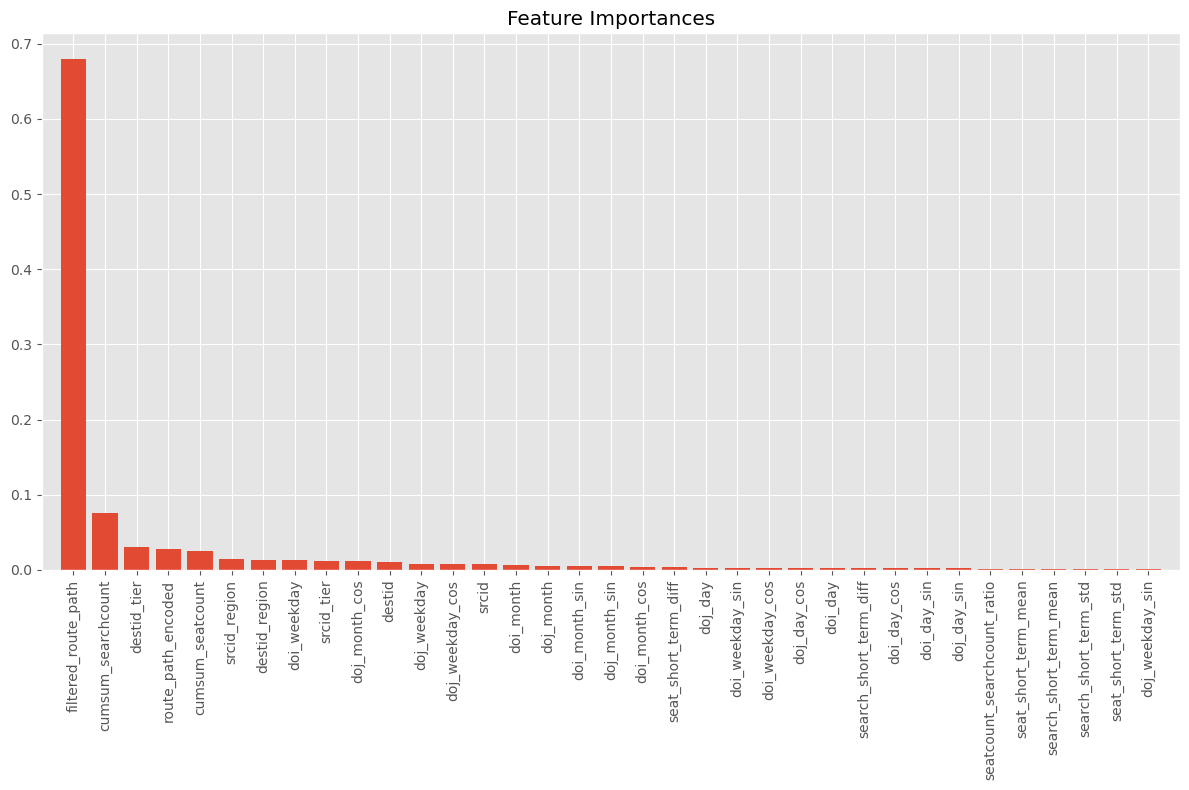

In [37]:
# Plot feature importances sorted by importance
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [38]:
top_features = list(x_train.columns[indices][:])

# Subset the training and testing data with the selected features
x_train_top = x_train[top_features]
x_test_top = x_test[top_features]
x_top = X[top_features]

In [39]:
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, random_seed=42, verbose=0)
catboost_model.fit(x_train, y_train)
y_test_preds_catboost = catboost_model.predict(x_test)
score_catboost = np.sqrt(mean_squared_error(y_test, y_test_preds_catboost))
print(f'CatBoost RMSE: {score_catboost}')

# Inverse log transformation for evaluation
y_test_preds_catboost_inv = np.expm1(y_test_preds_catboost)
y_test_inv_catboost = np.expm1(y_test)
# Calculate RMSE on the original scale
rmse_catboost = np.sqrt(mean_squared_error(y_test_inv_catboost, y_test_preds_catboost_inv))
print(f'CatBoost RMSE on original scale: {rmse_catboost}')

CatBoost RMSE: 0.14334793776935714
CatBoost RMSE on original scale: 364.3671680118005


In [40]:
lgbm_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
lgbm_model.fit(x_train, y_train)
y_test_preds_lgbm = lgbm_model.predict(x_test)
score_lgbm = np.sqrt(mean_squared_error(y_test, y_test_preds_lgbm))
print(f'LGBM RMSE: {score_lgbm}')
# Inverse log transformation for evaluation
y_test_preds_lgbm_inv = np.expm1(y_test_preds_lgbm)
y_test_inv_lgbm = np.expm1(y_test)
# Calculate RMSE on the original scale
rmse_lgbm = np.sqrt(mean_squared_error(y_test_inv_lgbm, y_test_preds_lgbm_inv))
print(f'LGBM RMSE on original scale: {rmse_lgbm}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2797
[LightGBM] [Info] Number of data points in the train set: 57120, number of used features: 35
[LightGBM] [Info] Start training from score 7.718171
LGBM RMSE: 0.13912166277674354
LGBM RMSE on original scale: 354.79597470896954


In [41]:
# # OPTUNA FOR LGBM
# def objective(trial):
#     params = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'boosting_type': 'gbdt',
#         'num_leaves': trial.suggest_int('num_leaves', 20, 100),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'random_state': 42,
#         'verbose': -1
#     }
    
#     model = lgb.LGBMRegressor(**params)
#     model.fit(x_train, y_train)
    
#     y_pred = model.predict(x_test)

#     y_test_preds_lgbm_inv = np.expm1(y_pred)
#     y_test_inv_lgbm = np.expm1(y_test)

#     rmse = np.sqrt(mean_squared_error(y_test_inv_lgbm, y_test_preds_lgbm_inv))
    
#     return rmse
# # Create a study object
# study = optuna.create_study(direction='minimize')
# # Optimize the objective function
# study.optimize(objective, n_trials=75)

# # Print the best parameters and the best score
# print("Best parameters:", study.best_params)

In [42]:
best_params = {'num_leaves': 98, 'max_depth': 10, 'learning_rate': 0.09992847921422109, 'n_estimators': 1058, 'subsample': 0.6340219238413192, 'colsample_bytree': 0.8640461561973884, 'verbose' : -1,  'random_state': 42, 'objective': 'regression', 'metric': 'rmse', 'boosting_type': 'gbdt'}

In [43]:
def create_target_weights(y):
    """Quick fix: weight samples by target value"""
    y_original = np.expm1(y)
    
    # Simple progressive weighting
    weights = np.log1p(y_original / 100)  # Higher values get higher weights
    weights = np.clip(weights, 0.5, 5.0)   # Reasonable weight range
    
    return weights

In [44]:
sample_weights = create_target_weights(y_train)
sample_weights.describe()

count    57120.000000
mean         3.160085
std          0.415431
min          1.752672
25%          2.905260
50%          3.119276
75%          3.395515
max          4.947198
Name: final_seatcount, dtype: float64

In [45]:
## Train the model with the best parameters
lgbm_model = lgb.LGBMRegressor(**best_params)
lgbm_model.fit(x_train, y_train, sample_weight= sample_weights)
y_test_preds_lgbm_optuna = lgbm_model.predict(x_test)
score_lgbm_optuna = np.sqrt(mean_squared_error(y_test, y_test_preds_lgbm_optuna))

print(f'LGBM with Optuna RMSE: {score_lgbm_optuna}')

# Inverse log transformation for evaluation
y_test_preds_lgbm_optuna_inv = np.expm1(y_test_preds_lgbm_optuna)
y_test_inv_lgbm_optuna = np.expm1(y_test)
# Calculate RMSE on the original scale
rmse_lgbm_optuna = np.sqrt(mean_squared_error(y_test_inv_lgbm_optuna, y_test_preds_lgbm_optuna_inv))
print(f'LGBM with Optuna RMSE on original scale: {rmse_lgbm_optuna}')

LGBM with Optuna RMSE: 0.13606461616144422
LGBM with Optuna RMSE on original scale: 347.7872720969327


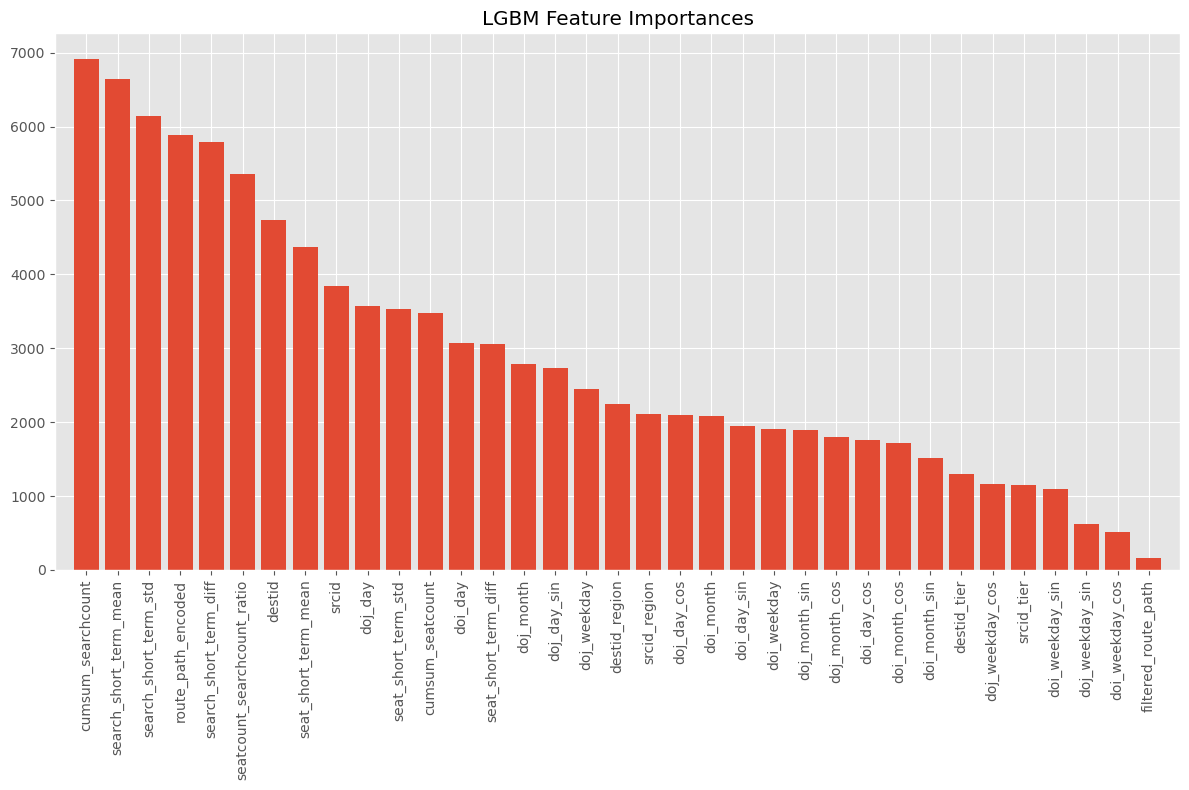

In [46]:
# Feature importance plot for LGBM
importances_lgbm = lgbm_model.feature_importances_
indices_lgbm = np.argsort(importances_lgbm)[::-1]
plt.figure(figsize=(12, 8))
plt.title("LGBM Feature Importances")
plt.bar(range(x_train.shape[1]), importances_lgbm[indices_lgbm], align='center')
plt.xticks(range(x_train.shape[1]), x_train.columns[indices_lgbm], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
# K-Fold Cross-Validation for LGBM
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
lgbm_cv_scores = []
lgbm_inv_log_cv_scores = []
count = 0
for train_index, val_index in kf.split(x_top):
    count += 1
    x_train_fold, x_val_fold = x_top.iloc[train_index], x_top.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    sample_weights = create_target_weights(y_train_fold)
    
    lgbm_model.fit(x_train_fold, y_train_fold, sample_weight= sample_weights)
    # Pickle the lightgbm model for later use
    lightgbm_model_path = f'lgbm_model_{count}.pkl'
    lgbm_model.booster_.save_model(lightgbm_model_path)

    # log metrics
    y_val_preds = lgbm_model.predict(x_val_fold)
    score = np.sqrt(mean_squared_error(y_val_fold, y_val_preds))
    lgbm_cv_scores.append(score)
    print(f'Fold RMSE: {score}')

    # Inverse log transformation for evaluation
    y_val_preds_inv = np.expm1(y_val_preds)
    y_val_fold_inv = np.expm1(y_val_fold)
    # Calculate RMSE on the original scale
    rmse_val = np.sqrt(mean_squared_error(y_val_fold_inv, y_val_preds_inv))
    print(f'LGBM K-Fold CV RMSE on original scale: {rmse_val}')
    lgbm_inv_log_cv_scores.append(rmse_val)


# Print the average RMSE across all folds
print(f'LGBM K-Fold CV RMSE: {np.mean(lgbm_cv_scores)}')
print(f'LGBM K-Fold CV RMSE on original scale: {np.mean(lgbm_inv_log_cv_scores)}')

Fold RMSE: 0.13505574588567598
LGBM K-Fold CV RMSE on original scale: 347.43469618305016
Fold RMSE: 0.13391512968512462
LGBM K-Fold CV RMSE on original scale: 339.90046868184714


In [ ]:
# Load all the saved models to get predictions
import lightgbm as lgb
def load_lightgbm_model(model_path):
    model = lgb.Booster(model_file=model_path)
    return model

# Load all models and get predictions
model_paths = [f'lgbm_model_{i}.pkl' for i in range(1, count + 1)]
predictions = []
for model_path in model_paths:
    model = load_lightgbm_model(model_path)
    preds = np.expm1(model.predict(test_df[top_features]))
    predictions.append(preds)
# Average predictions from all models
preds = np.mean(predictions, axis=0)
preds

In [ ]:
# preds = lgbm_model.predict(test_df[top_features])

In [ ]:
sub_df = sample_submission
sub_df['final_seatcount'] = preds
sub_df

In [ ]:
sns.kdeplot(sub_df['final_seatcount'], label='Predicted Seat Count', color='blue')
sns.kdeplot(np.expm1(y), label='Actual Seat Count', color='orange')
plt.title('Distribution of Predicted vs Actual Seat Count')
plt.legend()

In [ ]:
# # Inverse log transformation for visualization
# predicted_seat_count = np.expm1(sub_df['final_seatcount'])
# actual_seat_count = np.expm1(y)
# plt.figure(figsize=(12, 6))
# sns.kdeplot(predicted_seat_count, label='Predicted Seat Count', color='blue')
# sns.kdeplot(actual_seat_count, label='Actual Seat Count', color='orange')
# plt.title('Distribution of Predicted vs Actual Seat Count')
# plt.legend()

In [ ]:
# sub_df['final_seatcount'] = np.expm1(sub_df['final_seatcount']).round(0)
sub_df['final_seatcount'] = sub_df['final_seatcount'].clip(lower=0).round(0)
sub_df.to_csv('submission_m.csv', index=False)
sub_df